## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogscats/"
sz=299
arch=resnext50
bs=28

In [3]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [4]:
torch.cuda.is_available()

True

In [5]:
learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.034766   0.019664   0.99289   



In [6]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.0429     0.022917   0.990906  
    1      0.037759   0.018624   0.994544  



[0.018623501, 0.9945436533954408]

In [7]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [8]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.042434   0.016393   0.994048  
    1      0.033062   0.01583    0.995536  
    2      0.032537   0.017331   0.993552  



[0.017330803, 0.99355159037643]

In [8]:
learn.save('224_all_50')

In [9]:
learn.load('224_all_50')

In [9]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
#y = torch.LongTensor(y)

accuracy_np(probs,y)

0.9945

## Analyzing results

In [10]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[997   3]
 [  8 992]]


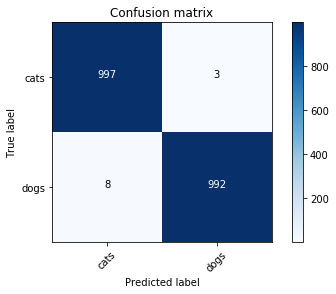

In [11]:
plot_confusion_matrix(cm, data.classes)

In [12]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


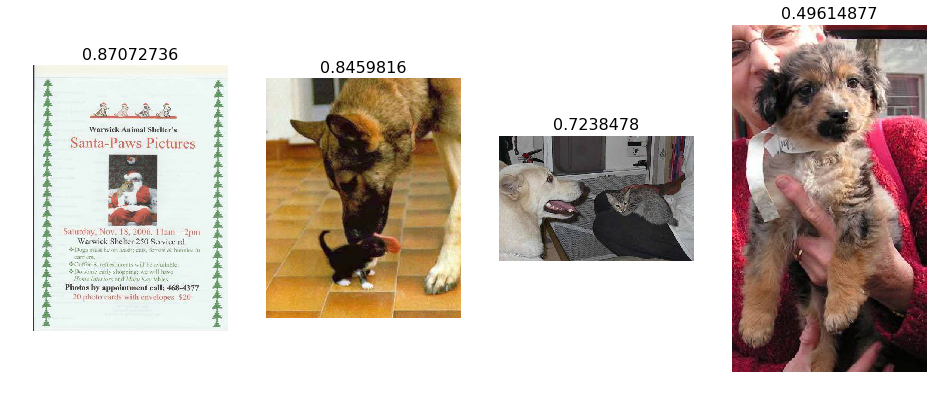

In [13]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


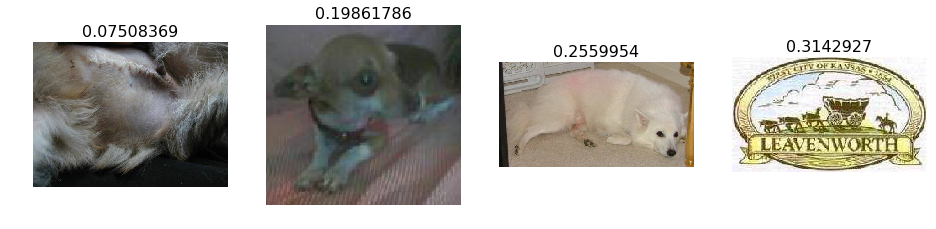

In [14]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")